# Wieloklasowa klasyfikacja tekstu
<p>Celem projektu było stworzenie modelu, który klasyfikuje wypowiedzi zgłaszane przez studentów z Indii przygotowujących się do egzaminów JEE Advanced, JEE Mains i NEET do jednej z kilku możliwych klas opisujących przedmiot związany z wypowiedzią.</p>

<h3> Import bibliotek </h3>

In [ ]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
stopwords.words('english')
import string
string.punctuation
from nltk.stem.porter import PorterStemmer
import optuna
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Conv1D, GlobalMaxPooling1D, GRU, GlobalAveragePooling1D

<h3> Podgląd zbioru danych </h3>

In [2]:
df = pd.read_csv("subjects-questions.csv")
df.head()

eng    Subject
0  An anti-forest measure is\nA. Afforestation\nB...    Biology
1  Among the following organic acids, the acid pr...  Chemistry
2  If the area of two similar triangles are equal...      Maths
3  In recent year, there has been a growing\nconc...    Biology
4  Which of the following statement\nregarding tr...    Physics

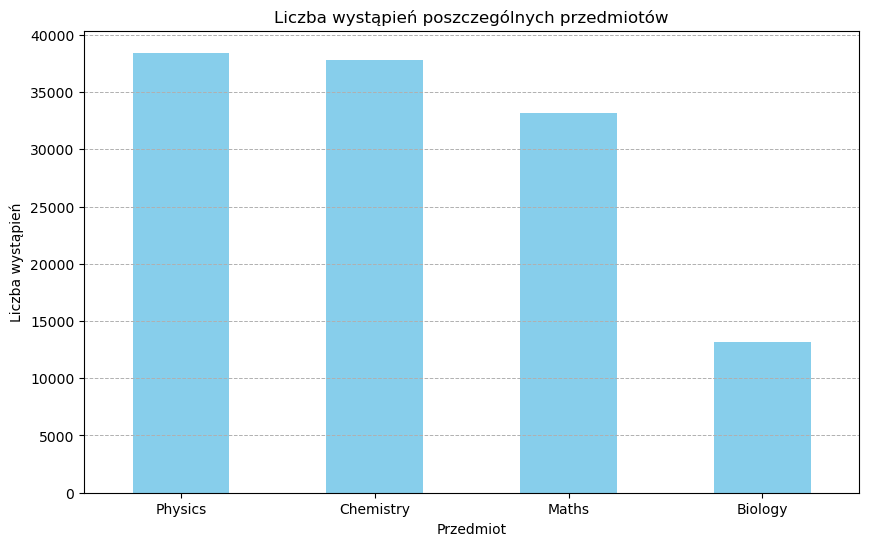

In [3]:
subject_counts = df['Subject'].value_counts()

plt.figure(figsize=(10, 6))
subject_counts.plot(kind='bar', color='skyblue')
plt.title('Liczba wystąpień poszczególnych przedmiotów')
plt.xlabel('Przedmiot')
plt.ylabel('Liczba wystąpień')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
plt.show()

<h3> Preprocessing danych </h3>

In [4]:
df = pd.get_dummies(df, columns=['Subject'])
df.head()

eng  Subject_Biology  \
0  An anti-forest measure is\nA. Afforestation\nB...             True   
1  Among the following organic acids, the acid pr...            False   
2  If the area of two similar triangles are equal...            False   
3  In recent year, there has been a growing\nconc...             True   
4  Which of the following statement\nregarding tr...            False   

   Subject_Chemistry  Subject_Maths  Subject_Physics  
0              False          False            False  
1               True          False            False  
2              False           True            False  
3              False          False            False  
4              False          False             True

In [6]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

def clean_text(text):
    text = re.sub(r'\n', ' ', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    text = text.lower()  
    text = ' '.join(text.split())
    return text

def stem_text(text):
    stemmer = PorterStemmer()
    token_words = word_tokenize(text)
    stem_sentence = [stemmer.stem(word) for word in token_words]
    return " ".join(stem_sentence)

In [7]:
df['prepared_text'] = df['eng'].apply(remove_stopwords)
df['prepared_text'] = df['eng'].apply(lemmatize_text)
df['prepared_text'] = df['eng'].apply(clean_text)
df['prepared_text'] = df['eng'].apply(stem_text)
df.head()

eng  Subject_Biology  \
0  An anti-forest measure is\nA. Afforestation\nB...             True   
1  Among the following organic acids, the acid pr...            False   
2  If the area of two similar triangles are equal...            False   
3  In recent year, there has been a growing\nconc...             True   
4  Which of the following statement\nregarding tr...            False   

   Subject_Chemistry  Subject_Maths  Subject_Physics  \
0              False          False            False   
1               True          False            False   
2              False           True            False   
3              False          False            False   
4              False          False             True   

                                       prepared_text  
0  an anti-forest measur is a. afforest b . selec...  
1  among the follow organ acid , the acid present...  
2  if the area of two similar triangl are equal ,...  
3  in recent year , there ha been a grow concern ...  
4  which of the follow statement regard transform...

In [8]:
df.to_csv("subjects-questions-prepared.csv")

In [58]:
X = df['prepared_text'] 
y = df[['Subject_Biology', 'Subject_Chemistry', 'Subject_Maths', 'Subject_Physics']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X))
print(len(X_train))
print(len(X_test))

122519
98015
24504


In [11]:
max_words = df['prepared_text'].str.len().max()
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(train_sequences, maxlen=5, padding='post', truncating='post')
padded_test = pad_sequences(test_sequences, maxlen=5, padding='post', truncating='post')


<h3> Definicja modeli </h3>

<h4> Model 1 </h4>
<p>Model składający się z warstw Embedding, LSTM, GlobalAveragePooling1D oraz kilku warstw Dense</p>

In [14]:
model_1 = Sequential()

model_1.add(Embedding(input_dim=10000, output_dim=16))
model_1.add(LSTM(units=64, return_sequences=True))
model_1.add(GlobalAveragePooling1D())
model_1.add(Dense(254, activation='relu'))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dense(4, activation='softmax'))

model_1.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.TruePositives(name='tp'),
                       tf.keras.metrics.FalsePositives(name='fp'),
                       tf.keras.metrics.TrueNegatives(name='tn'),
                       tf.keras.metrics.FalseNegatives(name='fn')])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160000    
                                                                 
 lstm_1 (LSTM)               (None, None, 64)          20736     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense (Dense)               (None, 254)               16510     
                                                                 
 dense_1 (Dense)             (None, 128)               32640     
                                                                 
 dense_2 (Dense)             (None, 4)                 516       
                                                      

<h4> Model 2 </h4>
<p>Model konwolucyjny z warstwą Embedding i jedną warstwą konwolucyjną 1D</p>

In [15]:
model_2 = Sequential()

model_2.add(Embedding(input_dim=10000, output_dim=16))
model_2.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model_2.add(GlobalMaxPooling1D())
model_2.add(Dense(4, activation='softmax'))
model_2.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.TruePositives(name='tp'),
                       tf.keras.metrics.FalsePositives(name='fp'),
                       tf.keras.metrics.TrueNegatives(name='tn'),
                       tf.keras.metrics.FalseNegatives(name='fn')])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          160000    
                                                                 
 conv1d (Conv1D)             (None, None, 128)         10368     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 170,884
Trainable params: 170,884
Non-trainable params: 0
_________________________________________________________________


<h4> Model 3 </h4>
<p>Model rekurencyjny z warstwą Embedding i jedną warstwą GRU</p>

In [23]:
model_3 = Sequential()

model_3.add(Embedding(input_dim=10000, output_dim=16))
model_3.add(GRU(units=64))
model_3.add(Dense(units=4, activation='softmax'))
model_3.compile(optimizer='adam', loss='categorical_crossentropy', 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.TruePositives(name='tp'),
                       tf.keras.metrics.FalsePositives(name='fp'),
                       tf.keras.metrics.TrueNegatives(name='tn'),
                       tf.keras.metrics.FalseNegatives(name='fn')])

model_3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 16)          160000    
                                                                 
 gru_1 (GRU)                 (None, 64)                15744     
                                                                 
 dense_5 (Dense)             (None, 4)                 260       
                                                                 
Total params: 176,004
Trainable params: 176,004
Non-trainable params: 0
_________________________________________________________________


<h3> Trening i walidacja modeli </h3>

In [25]:
def checkpoint(model_name):
    return ModelCheckpoint(filepath='best_model_'+ model_name +'.h5', monitor='val_accuracy', save_best_only=True)

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [26]:
history = model_1.fit(padded_train, y_train,
                    steps_per_epoch = 30,
                    epochs = 100,
                    validation_split=0.2,
                    verbose = 1,
                    validation_steps = 50,
                    callbacks=[checkpoint("1"), early_stopping, reduce_lr], 
                    )

Epoch 1/100
30/30 [==============================] - 1s 47ms/step - loss: 0.3951 - accuracy: 0.8490 - precision: 0.8730 - recall: 0.8248 - auc: 0.9727 - tp: 64673.0000 - fp: 9412.0000 - tn: 225824.0000 - fn: 13739.0000 - val_loss: 0.5155 - val_accuracy: 0.8170 - val_precision: 0.8458 - val_recall: 0.7902 - val_auc: 0.9559 - val_tp: 15490.0000 - val_fp: 2823.0000 - val_tn: 55986.0000 - val_fn: 4113.0000 - lr: 2.0000e-04
Epoch 2/100
30/30 [==============================] - 1s 41ms/step - loss: 0.3950 - accuracy: 0.8484 - precision: 0.8742 - recall: 0.8232 - auc: 0.9727 - tp: 64545.0000 - fp: 9290.0000 - tn: 225946.0000 - fn: 13867.0000 - val_loss: 0.5165 - val_accuracy: 0.8174 - val_precision: 0.8442 - val_recall: 0.7933 - val_auc: 0.9558 - val_tp: 15552.0000 - val_fp: 2871.0000 - val_tn: 55938.0000 - val_fn: 4051.0000 - lr: 2.0000e-04
Epoch 3/100
30/30 [==============================] - 1s 40ms/step - loss: 0.3944 - accuracy: 0.8490 - precision: 0.8732 - recall: 0.8252 - auc: 0.9727 - t

In [45]:
score = model_1.evaluate(padded_test, y_test, verbose=0)

print("Loss:", score[0])
print("Accuracy:", score[1])
print("Precision:", score[2])
print("Recall:", score[3])
print("AUC:", score[4])
print("True Positives:", score[5])
print("False Positives:", score[6])
print("True Negatives:", score[7])
print("False Negatives:", score[8])

Loss: 0.5143917202949524
Accuracy: 0.8162341117858887
Precision: 0.8397026062011719
Recall: 0.7926868796348572
AUC: 0.9560295343399048
True Positives: 19424.0
False Positives: 3708.0
True Negatives: 69804.0
False Negatives: 5080.0


In [49]:
history = model_2.fit(padded_train, y_train,
                    steps_per_epoch = 30,
                    epochs = 100,
                    validation_split=0.2,
                    verbose = 1,
                    validation_steps = 50,
                    callbacks=[checkpoint("2"), early_stopping, reduce_lr], 
                    )

Epoch 1/100
30/30 [==============================] - 1s 40ms/step - loss: 0.3013 - accuracy: 0.8852 - precision: 0.9036 - recall: 0.8683 - auc: 0.9840 - tp: 68085.0000 - fp: 7263.0000 - tn: 227973.0000 - fn: 10327.0000 - val_loss: 0.5586 - val_accuracy: 0.8162 - val_precision: 0.8363 - val_recall: 0.8018 - val_auc: 0.9532 - val_tp: 15717.0000 - val_fp: 3076.0000 - val_tn: 55733.0000 - val_fn: 3886.0000 - lr: 1.0000e-04
Epoch 2/100
30/30 [==============================] - 1s 33ms/step - loss: 0.3011 - accuracy: 0.8855 - precision: 0.9035 - recall: 0.8686 - auc: 0.9840 - tp: 68112.0000 - fp: 7272.0000 - tn: 227964.0000 - fn: 10300.0000 - val_loss: 0.5590 - val_accuracy: 0.8162 - val_precision: 0.8359 - val_recall: 0.8020 - val_auc: 0.9532 - val_tp: 15722.0000 - val_fp: 3087.0000 - val_tn: 55722.0000 - val_fn: 3881.0000 - lr: 1.0000e-04
Epoch 3/100
30/30 [==============================] - 1s 36ms/step - loss: 0.3008 - accuracy: 0.8855 - precision: 0.9037 - recall: 0.8684 - auc: 0.9840 - t

In [50]:
score = model_2.evaluate(padded_test, y_test, verbose=0)

print("Loss:", score[0])
print("Accuracy:", score[1])
print("Precision:", score[2])
print("Recall:", score[3])
print("AUC:", score[4])
print("True Positives:", score[5])
print("False Positives:", score[6])
print("True Negatives:", score[7])
print("False Negatives:", score[8])

Loss: 0.5664545297622681
Accuracy: 0.8139079213142395
Precision: 0.8310044407844543
Recall: 0.7984818816184998
AUC: 0.9523454308509827
True Positives: 19566.0
False Positives: 3979.0
True Negatives: 69533.0
False Negatives: 4938.0


In [28]:
history = model_3.fit(padded_train, y_train,
                    steps_per_epoch = 30,
                    epochs = 100,
                    validation_split=0.2,
                    verbose = 1,
                    validation_steps = 50,
                    callbacks=[checkpoint("3"), early_stopping, reduce_lr], 
                    )

Epoch 1/100
30/30 [==============================] - 1s 43ms/step - loss: 0.3993 - accuracy: 0.8482 - precision: 0.8744 - recall: 0.8214 - auc: 0.9722 - tp: 64409.0000 - fp: 9252.0000 - tn: 225984.0000 - fn: 14003.0000 - val_loss: 0.4974 - val_accuracy: 0.8173 - val_precision: 0.8476 - val_recall: 0.7934 - val_auc: 0.9581 - val_tp: 15553.0000 - val_fp: 2796.0000 - val_tn: 56013.0000 - val_fn: 4050.0000 - lr: 2.0000e-04
Epoch 2/100
30/30 [==============================] - 1s 39ms/step - loss: 0.3986 - accuracy: 0.8482 - precision: 0.8742 - recall: 0.8219 - auc: 0.9722 - tp: 64443.0000 - fp: 9272.0000 - tn: 225964.0000 - fn: 13969.0000 - val_loss: 0.4981 - val_accuracy: 0.8167 - val_precision: 0.8492 - val_recall: 0.7896 - val_auc: 0.9580 - val_tp: 15479.0000 - val_fp: 2749.0000 - val_tn: 56060.0000 - val_fn: 4124.0000 - lr: 2.0000e-04
Epoch 3/100
30/30 [==============================] - 1s 42ms/step - loss: 0.3982 - accuracy: 0.8486 - precision: 0.8749 - recall: 0.8209 - auc: 0.9723 - t

In [48]:
score = model_3.evaluate(padded_test, y_test, verbose=0)

print("Loss:", score[0])
print("Accuracy:", score[1])
print("Precision:", score[2])
print("Recall:", score[3])
print("AUC:", score[4])
print("True Positives:", score[5])
print("False Positives:", score[6])
print("True Negatives:", score[7])
print("False Negatives:", score[8])

Loss: 0.5007005929946899
Accuracy: 0.816642165184021
Precision: 0.8432700037956238
Recall: 0.7930949926376343
AUC: 0.9578227400779724
True Positives: 19434.0
False Positives: 3612.0
True Negatives: 69900.0
False Negatives: 5070.0


<h3> Eksperymenty </h3>
<h4> Trening i waldacja modelu 2 na wszystkich epokach </h4>

In [51]:
history = model_2.fit(padded_train, y_train,
                    steps_per_epoch = 30,
                    epochs = 100,
                    validation_split=0.2,
                    verbose = 1,
                    validation_steps = 50,
                    callbacks=[checkpoint("2_all_epochs"), reduce_lr], 
                    )

Epoch 1/100
30/30 [==============================] - 1s 42ms/step - loss: 0.2998 - accuracy: 0.8859 - precision: 0.9040 - recall: 0.8694 - auc: 0.9841 - tp: 68169.0000 - fp: 7240.0000 - tn: 227996.0000 - fn: 10243.0000 - val_loss: 0.5619 - val_accuracy: 0.8164 - val_precision: 0.8352 - val_recall: 0.8020 - val_auc: 0.9529 - val_tp: 15722.0000 - val_fp: 3102.0000 - val_tn: 55707.0000 - val_fn: 3881.0000 - lr: 1.0000e-04
Epoch 2/100
30/30 [==============================] - 1s 37ms/step - loss: 0.2996 - accuracy: 0.8859 - precision: 0.9039 - recall: 0.8695 - auc: 0.9841 - tp: 68178.0000 - fp: 7252.0000 - tn: 227984.0000 - fn: 10234.0000 - val_loss: 0.5626 - val_accuracy: 0.8164 - val_precision: 0.8357 - val_recall: 0.8019 - val_auc: 0.9528 - val_tp: 15719.0000 - val_fp: 3091.0000 - val_tn: 55718.0000 - val_fn: 3884.0000 - lr: 1.0000e-04
Epoch 3/100
30/30 [==============================] - 1s 41ms/step - loss: 0.2994 - accuracy: 0.8860 - precision: 0.9041 - recall: 0.8691 - auc: 0.9842 - t

In [53]:
score = model_2.evaluate(padded_test, y_test, verbose=0)

print("Loss:", score[0])
print("Accuracy:", score[1])
print("Precision:", score[2])
print("Recall:", score[3])
print("AUC:", score[4])
print("True Positives:", score[5])
print("False Positives:", score[6])
print("True Negatives:", score[7])
print("False Negatives:", score[8])

Loss: 0.6283017992973328
Accuracy: 0.8093372583389282
Precision: 0.8246207237243652
Recall: 0.7963189482688904
AUC: 0.9471717476844788
True Positives: 19513.0
False Positives: 4150.0
True Negatives: 69362.0
False Negatives: 4991.0


<h4> Fine tune modelu 2 </h4>

In [64]:
def objective(trial):
    
    num_filters = trial.suggest_int('num_filters', 32, 256)
    kernel_size = trial.suggest_int('kernel_size', 3, 5)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    model_2_fine_tune = Sequential([
        Embedding(input_dim=10000, output_dim=16),
        Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(4, activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)

    model_2_fine_tune.compile(optimizer=optimizer, loss='categorical_crossentropy', 
              metrics=['accuracy', 
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc'),
                       tf.keras.metrics.TruePositives(name='tp'),
                       tf.keras.metrics.FalsePositives(name='fp'),
                       tf.keras.metrics.TrueNegatives(name='tn'),
                       tf.keras.metrics.FalseNegatives(name='fn')])

    model_2_fine_tune.fit(padded_train, y_train,
                    steps_per_epoch = 30,
                    epochs = 100,
                    validation_split=0.2,
                    verbose = 1,
                    validation_steps = 50,
                    callbacks=[checkpoint("2_fine_tune"), reduce_lr], 
                    )

    score = model_2_fine_tune.evaluate(padded_test, y_test, verbose=0)
    
    print("Loss:", score[0])
    print("Accuracy:", score[1])
    print("Precision:", score[2])
    print("Recall:", score[3])
    print("AUC:", score[4])
    print("True Positives:", score[5])
    print("False Positives:", score[6])
    print("True Negatives:", score[7])
    print("False Negatives:", score[8])
    
    return score[1]

study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=5)

[I 2024-06-08 13:54:59,853] A new study created in memory with name: no-name-2054c194-0d55-4969-91e6-f0f12af54a54
C:\Users\Michał\AppData\Local\Temp\ipykernel_33252\265862631.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


Epoch 1/100
30/30 [==============================] - 3s 50ms/step - loss: 1.3636 - accuracy: 0.4293 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6770 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 235236.0000 - fn: 78412.0000 - val_loss: 1.3366 - val_accuracy: 0.5192 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7490 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 58809.0000 - val_fn: 19603.0000 - lr: 5.8385e-04
Epoch 2/100
30/30 [==============================] - 1s 22ms/step - loss: 1.2935 - accuracy: 0.5733 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7779 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 235236.0000 - fn: 78412.0000 - val_loss: 1.2388 - val_accuracy: 0.6064 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8067 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 58809.0000 - val_fn: 19603.0000 - lr: 5.8385e-04
Epoch 3/100
30/30 [==============================] - 1s 21ms/step - loss: 1.1618 - accuracy: 0.6429 - precision: 0.8

[I 2024-06-08 13:56:09,227] Trial 0 finished with value: 0.819294810295105 and parameters: {'num_filters': 37, 'kernel_size': 5, 'learning_rate': 0.0005838498821337493}. Best is trial 0 with value: 0.819294810295105.


Loss: 0.5012595057487488
Accuracy: 0.819294810295105
Precision: 0.840825080871582
Recall: 0.7984818816184998
AUC: 0.9585517644882202
True Positives: 19566.0
False Positives: 3704.0
True Negatives: 69808.0
False Negatives: 4938.0
Epoch 1/100


C:\Users\Michał\AppData\Local\Temp\ipykernel_33252\265862631.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


30/30 [==============================] - 4s 56ms/step - loss: 1.3706 - accuracy: 0.3701 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6488 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 235236.0000 - fn: 78412.0000 - val_loss: 1.3552 - val_accuracy: 0.4174 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7013 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 58809.0000 - val_fn: 19603.0000 - lr: 3.9476e-04
Epoch 2/100
30/30 [==============================] - 1s 20ms/step - loss: 1.3383 - accuracy: 0.4456 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7218 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 235236.0000 - fn: 78412.0000 - val_loss: 1.3198 - val_accuracy: 0.4690 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7383 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 58809.0000 - val_fn: 19603.0000 - lr: 3.9476e-04
Epoch 3/100
30/30 [==============================] - 1s 20ms/step - loss: 1.2942 - accuracy: 0.5060 - precision: 0.0000e+00 - re

[I 2024-06-08 13:57:17,306] Trial 1 finished with value: 0.817417562007904 and parameters: {'num_filters': 42, 'kernel_size': 3, 'learning_rate': 0.0003947618323958337}. Best is trial 0 with value: 0.819294810295105.


Loss: 0.5054721236228943
Accuracy: 0.817417562007904
Precision: 0.8435232043266296
Recall: 0.7921971678733826
AUC: 0.9574187994003296
True Positives: 19412.0
False Positives: 3601.0
True Negatives: 69911.0
False Negatives: 5092.0
Epoch 1/100


C:\Users\Michał\AppData\Local\Temp\ipykernel_33252\265862631.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


30/30 [==============================] - 4s 68ms/step - loss: 1.3464 - accuracy: 0.3959 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6587 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 235236.0000 - fn: 78412.0000 - val_loss: 1.3003 - val_accuracy: 0.4699 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7196 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 58809.0000 - val_fn: 19603.0000 - lr: 7.1779e-04
Epoch 2/100
30/30 [==============================] - 1s 22ms/step - loss: 1.2216 - accuracy: 0.5570 - precision: 0.7692 - recall: 0.0037 - auc: 0.7741 - tp: 290.0000 - fp: 87.0000 - tn: 235149.0000 - fn: 78122.0000 - val_loss: 1.1120 - val_accuracy: 0.6276 - val_precision: 0.8292 - val_recall: 0.0574 - val_auc: 0.8277 - val_tp: 1126.0000 - val_fp: 232.0000 - val_tn: 58577.0000 - val_fn: 18477.0000 - lr: 7.1779e-04
Epoch 3/100
30/30 [==============================] - 1s 23ms/step - loss: 0.9687 - accuracy: 0.6730 - precision: 0.8559 - recall: 0.3230 - auc: 0.8647 -

[I 2024-06-08 13:58:26,323] Trial 2 finished with value: 0.816274881362915 and parameters: {'num_filters': 124, 'kernel_size': 4, 'learning_rate': 0.0007177946981171184}. Best is trial 0 with value: 0.819294810295105.


Loss: 0.5146223902702332
Accuracy: 0.816274881362915
Precision: 0.8387221693992615
Recall: 0.7960740923881531
AUC: 0.9571151733398438
True Positives: 19507.0
False Positives: 3751.0
True Negatives: 69761.0
False Negatives: 4997.0
Epoch 1/100


C:\Users\Michał\AppData\Local\Temp\ipykernel_33252\265862631.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


30/30 [==============================] - 3s 46ms/step - loss: 1.3620 - accuracy: 0.3614 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6527 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 235236.0000 - fn: 78412.0000 - val_loss: 1.3293 - val_accuracy: 0.4581 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.7289 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 58809.0000 - val_fn: 19603.0000 - lr: 6.1312e-04
Epoch 2/100
30/30 [==============================] - 1s 19ms/step - loss: 1.2758 - accuracy: 0.5298 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.7566 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 235236.0000 - fn: 78412.0000 - val_loss: 1.1994 - val_accuracy: 0.6011 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8021 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 58809.0000 - val_fn: 19603.0000 - lr: 6.1312e-04
Epoch 3/100
30/30 [==============================] - 1s 19ms/step - loss: 1.0835 - accuracy: 0.6464 - precision: 0.8711 - recall

[I 2024-06-08 13:59:32,822] Trial 3 finished with value: 0.8176215887069702 and parameters: {'num_filters': 156, 'kernel_size': 3, 'learning_rate': 0.0006131200612586219}. Best is trial 0 with value: 0.819294810295105.


Loss: 0.517291784286499
Accuracy: 0.8176215887069702
Precision: 0.8432790637016296
Recall: 0.7946865558624268
AUC: 0.9564386010169983
True Positives: 19473.0
False Positives: 3619.0
True Negatives: 69893.0
False Negatives: 5031.0
Epoch 1/100


C:\Users\Michał\AppData\Local\Temp\ipykernel_33252\265862631.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)


30/30 [==============================] - 3s 50ms/step - loss: 1.1794 - accuracy: 0.5739 - precision: 0.8297 - recall: 0.1232 - auc: 0.7761 - tp: 9664.0000 - fp: 1984.0000 - tn: 233252.0000 - fn: 68748.0000 - val_loss: 0.8664 - val_accuracy: 0.6758 - val_precision: 0.7996 - val_recall: 0.5232 - val_auc: 0.8750 - val_tp: 10257.0000 - val_fp: 2570.0000 - val_tn: 56239.0000 - val_fn: 9346.0000 - lr: 0.0026
Epoch 2/100
30/30 [==============================] - 1s 20ms/step - loss: 0.6760 - accuracy: 0.7388 - precision: 0.8258 - recall: 0.6619 - auc: 0.9236 - tp: 51902.0000 - fp: 10946.0000 - tn: 224290.0000 - fn: 26510.0000 - val_loss: 0.5842 - val_accuracy: 0.7770 - val_precision: 0.8348 - val_recall: 0.7061 - val_auc: 0.9421 - val_tp: 13842.0000 - val_fp: 2739.0000 - val_tn: 56070.0000 - val_fn: 5761.0000 - lr: 0.0026
Epoch 3/100
30/30 [==============================] - 1s 21ms/step - loss: 0.5043 - accuracy: 0.8162 - precision: 0.8599 - recall: 0.7563 - auc: 0.9568 - tp: 59300.0000 - fp: 

[I 2024-06-08 14:01:04,384] Trial 4 finished with value: 0.815499484539032 and parameters: {'num_filters': 86, 'kernel_size': 5, 'learning_rate': 0.0026465008265824665}. Best is trial 0 with value: 0.819294810295105.


Loss: 0.558591902256012
Accuracy: 0.815499484539032
Precision: 0.8317180871963501
Recall: 0.7985227108001709
AUC: 0.95306795835495
True Positives: 19567.0
False Positives: 3959.0
True Negatives: 69553.0
False Negatives: 4937.0


In [65]:
print("Najlepsze wartości hiperparametrów:", study.best_params)
print("Wartość metryki dla najlepszych hiperparametrów:", study.best_value)

Najlepsze wartości hiperparametrów: {'num_filters': 37, 'kernel_size': 5, 'learning_rate': 0.0005838498821337493}
Wartość metryki dla najlepszych hiperparametrów: 0.819294810295105
